author: Vladimir Eremin

email: eremin.vladimir.d@gmail.com


HOW TO READ THIS NOTEBOOK:
This notebook has several sections:
- Util functions that generate plots, train models and print out statistics
Feel free to skip these ones unless you're interested in-deep on how results are generated
NOTE: Some of the util functions I took from the open-source code (e.g. print ROC curve) and others are written by myself (and a mix of that)

- Execution of functions
    The output of the analysis fitted with provided `test` dataset

- My comments
    I used python docstring ``` ``` to write down my thoughts through the analysis and model engineering and to describe results
    I used `#` to comment on some code for readability

    I split all processes into four sections: Explanatory Analysis, Data Processing, Model Engineering, Create Prediction. 
    Labeled with <section #>.<subsection #>


In [1]:
#install required packages if needed:
#!pip install ipykernel notebook numpy matplotlib pandas sklearn seaborn graphviz
#print versions 
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.pipeline import Pipeline

from utils import *

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier , plot_tree
from xgboost import plot_tree as plot_tree_xgb
from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
#disable warnings for viz 
import warnings
warnings.filterwarnings('ignore')


print('Python: ',sys.version)
print('pandas: ',pd.__version__)
print('sklearn: ',sklearn.__version__)
print('xgboost: ',xgboost.__version__)

Python:  3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 21:15:04) 
[GCC 7.3.0]
pandas:  1.1.5
sklearn:  0.24.1
xgboost:  1.4.1


In [2]:
#provide path to the input data:
output_file_name = 'predictions_churn_dataset_test.csv'

#train dataset:
path_to_train = 'input/churn_dataset_train.csv'

#random seed
RANDOM_SEED = 42

In [3]:
#1 - EXPLONATORY ANALYSIS 
#Read training dataset, print preview:
df_input = pd.read_csv(path_to_train)
print('Input shape:\n\n\n train:', df_input.shape)

Input shape:


 train: (3500, 20)


In [4]:
print('Train dataset:')
df_input.head()


Train dataset:


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,AR,173,area_code_408,no,no,0,154.6,81,26.28,147.3,100.0,12.52,132.9,99,5.98,6.9,5,1.86,0,no
1,ID,127,area_code_408,no,no,0,102.8,128,17.48,143.7,95.0,12.21,191.4,97,8.61,10.0,5,2.70,1,no
2,TX,91,area_code_415,no,no,0,251.5,57,42.76,179.1,113.0,15.22,163.2,72,7.34,6.6,3,1.78,1,no
3,ND,60,area_code_510,no,no,0,203.2,99,NaN,235.8,131.0,20.04,224.9,112,10.12,15.1,6,4.08,2,no
4,NV,83,area_code_510,no,yes,31,129.8,87,22.07,183.4,110.0,15.59,169.4,40,7.62,14.3,6,3.86,1,no


In [5]:
# We have provided with 19 input features and one target label

# 1.1 - Description analysis
# First thing I'll examine is a descriptive statistics:
#print statistics for each column:
for col in df_input.columns:
    print(df_input[col].describe(),'\n','-'*60)


count     3500
unique      51
top         WV
freq       111
Name: state, dtype: object 
 ------------------------------------------------------------
count    3500.000000
mean      100.062286
std        40.126972
min         1.000000
25%        73.000000
50%       100.000000
75%       127.000000
max       232.000000
Name: account_length, dtype: float64 
 ------------------------------------------------------------
count              3500
unique                3
top       area_code_415
freq               1721
Name: area_code, dtype: object 
 ------------------------------------------------------------
count     3500
unique       2
top         no
freq      3183
Name: international_plan, dtype: object 
 ------------------------------------------------------------
count     3500
unique       2
top         no
freq      2579
Name: voice_mail_plan, dtype: object 
 ------------------------------------------------------------
count    3500.000000
mean        7.654857
std        13.430216
min   

The following thing can be inferred from the descriptive statistics:
1) `state`: 51 unique values. It looks like we have data from all US states.
   It's a good sign since it reduces the risk of selection bias in our data.
     Let's bring the distribution of observations by state:

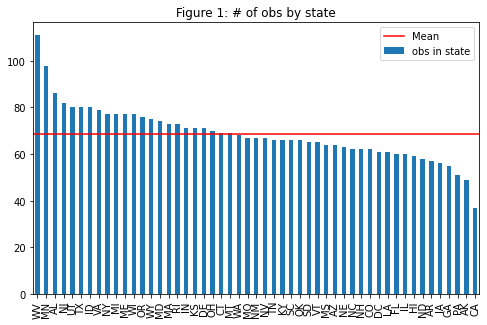

In [6]:

fig , ax = plt.subplots(figsize=(8,5))
df_input['state'].value_counts().plot.bar(ax=ax,label='obs in state')
ax.axhline(df_input['state'].value_counts().mean(),color='red',label='Mean')
ax.set(title='Figure 1: # of obs by state')
ax.legend();

From figure 1 we can see that WV, MN, AL are highly overrepresented in the dataset
whereas CA and AK are underrepresented.
To eliminate the Selection bias, we should clarify this distribution with data owners!

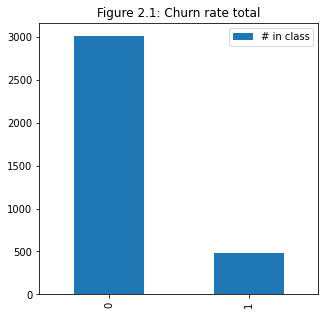

In [7]:
churn_total = (df_input.replace({'yes':1,'no':0}).churn).value_counts()
fig , ax = plt.subplots(figsize=(5,5))

churn_total.plot.bar(ax=ax,label='# in class')
ax.set(title='Figure 2.1: Churn rate total')
ax.legend();


We can see that `no` class is clearly underrepresented in this dataset (~14%) 
This will cause a challenge in creating a classification model since the accuracy score by itself
won't be that useful.
I assume the Recall measure is more suitable to capture the model's ability to identify churn customers.
I will also try resampling technics to balance classes in the training data.

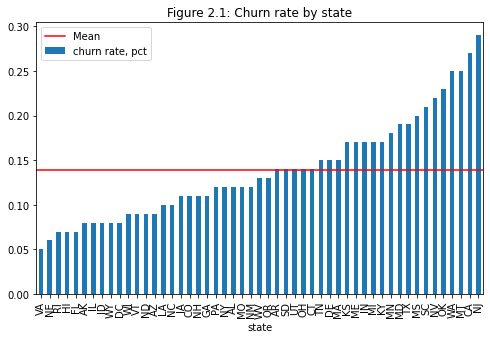

In [8]:
#Let's examine the churn rate by state
churn_by_state = (df_input.replace({'yes':1,'no':0})
                            .groupby('state')['churn']
                            .apply(lambda x: round(x.sum()/ x.count(),2))
                            .sort_values()
                    )
fig , ax = plt.subplots(figsize=(8,5))

churn_by_state.plot.bar(ax=ax,label='churn rate, pct')
ax.axhline(churn_by_state.mean(),color='red',label='Mean')
ax.set(title='Figure 2.1: Churn rate by state')
ax.legend();

Figure 2 shows an interesting story: The churn rate seems to be highly unbalanced state-by-state.
There might be several reasons for this including underrepresentation of the company in these regions,
high competitive pressure, or other factors. There's a story behind that, and it's a good follow-up
question to business people.
The decision we should make here whether or not to include the `state` variable in the model.
If it is included, the training score would certainly be higher since the geo-location itself can be a good predictor.
BUT with no information about the causes of this distribution, the model might fail to generalize new data.

2) `area_code`: there only three unique values. Why is that?
   From the glance, this variable doesn't provide much information 
  and is the candidate for exclusion

2) `account_length`: I assume this metric tends to trace how old the account in general.
       The client with a two-digit account length is assumed to be `older than the one with three or more. Numerical representation of this metric might not be relevant.
       I'll replace this metric to bins of # of digits: {2,3,...}

3) In all numerical variables min value is always zero (not below) which
   also is a good sign.

In [9]:

# I remove state variable in this exersice, to avoid geo bias in the model
# If 
vars_to_drop = ['area_code'
                ,'state' 
                ]

In [10]:
# Next one - sanity check of the provided dataset:
# define util function:

#print sanity check
sanity_stats = get_df_stats(df_input)
print(sanity_stats)

                          Feature  Unique_testues  \
8                total_day_charge            1608   
10                total_eve_calls             118   
11               total_eve_charge            1472   
18  number_customer_service_calls              10   
17              total_intl_charge             164   
16               total_intl_calls              21   
15             total_intl_minutes             164   
14             total_night_charge             946   
13              total_night_calls             124   
12            total_night_minutes            1636   
0                           state              51   
1                  account_length             212   
9               total_eve_minutes            1652   
7                 total_day_calls             118   
6               total_day_minutes            1670   
5           number_vmail_messages              46   
4                 voice_mail_plan               2   
3              international_plan             

Following things can be observed:
1) Our target variable `churn` doesn't have missing values, which is good.
2) We observe significant number of missing values in `total_day_charge` and `total_eve_calls` variables
   From the definition:- total_day_charge (total charge of day calls)
                         - total_eve_minutes (total minutes of evening calls)

Another thing that I noticed is that `Percentage of missing values` == `Percentage of values in the biggest category.`
I assume it's because of the missing values; let's validate:

In [11]:

print('total_day_charge:\n',df_input['total_day_charge'].fillna(-9999).value_counts().iloc[:3])
print('total_eve_calls:\n',df_input['total_eve_calls'].fillna(-9999).value_counts().iloc[:3])

total_day_charge:
 -9999.00    284
 32.18        8
 26.18        7
Name: total_day_charge, dtype: int64
total_eve_calls:
 -9999.0    231
 105.0      74
 108.0      73
Name: total_eve_calls, dtype: int64


In [12]:
print('Total pct of missing value: ',sanity_stats['Number of missing values'].sum() / df_input.shape[0] )


Total pct of missing value:  0.14714285714285713


We have 14% of missing values which is significant enough, so we cannot just drop these rows because it'll have a noticeable impact on the performance of the model. Hence, these two features must be treated either:
  - Fill values using some method (mean, median, etc.)
  - Remove these two features completely from the model if the model shows a small significance level


If it possible, it's good to know when data was collected to prevent potential data leakage:
We don't want our model to be trained on the future data and be validated on the past.
Even though it's not that critical for this exercise, this type of data leakage can affect the production model dramatically.

numerical variables: 
 ['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']
                               account_length  number_vmail_messages  \
account_length                           True                  False   
number_vmail_messages                   False                   True   
total_day_minutes                       False                  False   
total_day_calls                         False                  False   
total_day_charge                        False                  False   
total_eve_minutes                       False                  False   
total_eve_calls                         False                  False   
total_eve_charge                        False                  False   
tot

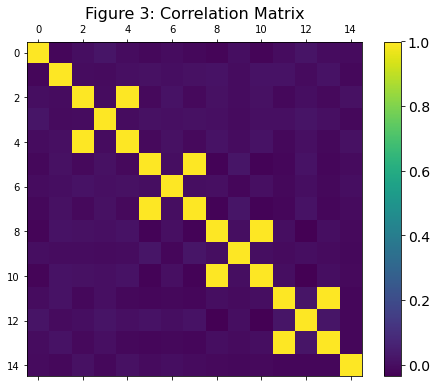

In [13]:
# 1.2 - Correlation Analysis
'''
In this dataset, most of the variables are related to some usage patterns:
num. of minutes, num. of calls, etc. I assume these variables could be highly correlated and hence hold redundant information.
'''
#plot correlation matrix for numerical features
num_varialbes = df_input.select_dtypes(include=np.number).columns.tolist()
numeric_features = df_input[num_varialbes]
print('numerical variables: \n', num_varialbes)
fig = plt.figure(figsize=(8, 6))
plt.matshow(numeric_features.corr(), fignum=fig.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Figure 3: Correlation Matrix', fontsize=16);
print(numeric_features.corr().abs().applymap(lambda x : x>.85))


Nice plot, isn't it? :)
But examine these regular correlation spikes, I found out that `_time` and `_charge` 
variables are highly correlated, and hence, one of them can be excluded. I'd prefer to use `_time` variable as a feature.


In [14]:
#extend the list of variables to exclude from the model
vars_to_drop.extend([c for c in numeric_features if '_charge' in c])

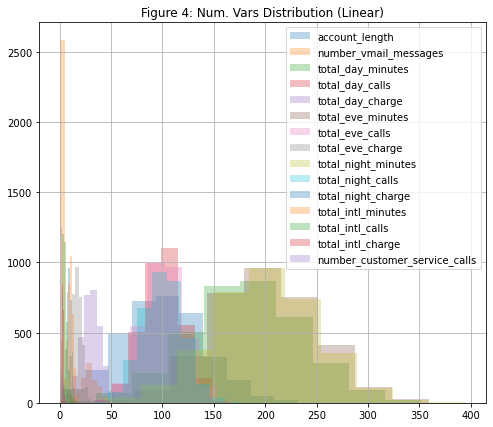

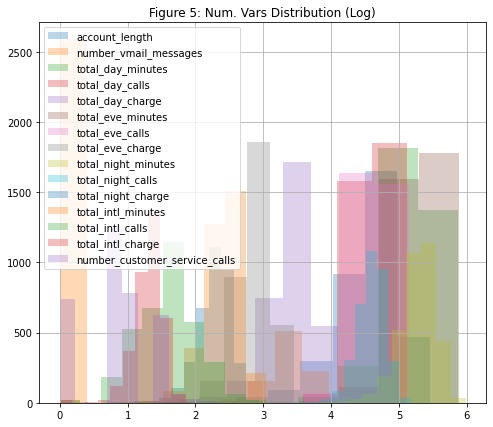

In [15]:
def plot_dist(log,title ):
    fig = plt.figure(figsize=(8, 7))
    ax = fig.gca()
    for col in num_varialbes:
        if log:
            np.log1p(df_input[col]).hist(ax=ax,alpha=.3,label=col)
        else:
            df_input[col].hist(ax=ax,alpha=.3,label=col)

    ax.set(title=title)
    ax.legend()

plot_dist(log=False, title='Figure 4: Num. Vars Distribution (Linear)')

#Let's plot the distribution of the log-transformed variables 
plot_dist(log=True, title='Figure 5: Num. Vars Distribution (Log)')


We can see that most numerical features are distributed "more-or-less normally'
but have a different scale. This needs to be handled!
Since  `*_total` variables tend to increase,in production through time,
these metrics will be accumulated and push the distribution in the axis right. To address this,
I'll use log(x+1) transform instead of norm() transform to address that.

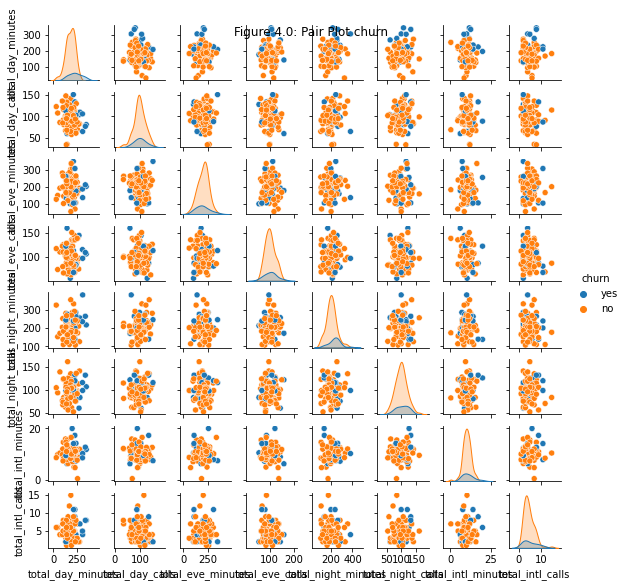

In [16]:
# A pair plot for `total_*` variables conditioned on three categorical variables:
cat_variable = ['international_plan'
                ,'voice_mail_plan'
                ,'churn']
total_vars = [c for c in df_input.columns if 'total_' in c and c not in vars_to_drop]
# total_vars = total_vars[:4]
sample_size = 100
def plot_pairplot():
    for i , col in enumerate(cat_variable[-1:]):
        
        #sample dataframe for performance/plot optimization
        df_toplot = (df_input[total_vars+[col]]
                    .sample(sample_size)
                    )
        #create pair plot
        ax = sns.pairplot(df_toplot,hue=col,size=1)
        fig = plt.gcf()
        fig.suptitle(f'Figure 4.{i}: Pair Plot {col}')
        # break
plot_pairplot()

- Interesting that there is an order in churn distribution  `total_day_minutes`

- All other plots are distributed pretty much evenly.

In [17]:
#2 - DATA PROCESSING 



In [18]:
target_label = 'churn'
#format featues names 
num_varialbes_touse = total_vars + [c for c in df_input.columns if 'number_' in c]
cat_variables_touse = [c for c in cat_variable if target_label not in c ]

#split featues-target variables 

df_totransform = df_input.copy()

#create the data pre-precessing object
processor = DataProcessing(num_varialbes_touse,cat_variables_touse
                            ,vars_to_drop=vars_to_drop,to_log1p=True)



X  , y = df_totransform.drop(target_label,axis=1) , df_totransform[[target_label]]

#Extract feature names for viz labeling 
X_ = processor.transform(X,y)
features_names = processor.features_names
columns_names = X.columns.tolist()


In [19]:
#3 - MODEL ENGINERING 

Before starting engineering any model I'll establish the baseline model and evaluation metrics:

Baseline model:
    - Most common classifier
    - Random classifier

Evaluation metric:
    1 - Recall score: minimizing the type 2 error 
    2 - Accuracy score

In [20]:
score_to_optimize = 'recall_score'

# 3.1 split input dataset on training- validation datasets - test dataset: Create Data Layer
dl = DataLayer(X,y,None,target_label,random_state=RANDOM_SEED)

def make_dummy_model(dl,strategy):
    '''
    A Wrapper for the dummy classifyer model
    '''
    print('*'*60,
        '\nDummy model with strategy: ', strategy)
    dummy_clf = Pipeline(steps = [('processing', DataProcessing(num_varialbes_touse,cat_variables_touse
                                                    ,vars_to_drop=vars_to_drop,to_log1p=True,columns_names=columns_names))
                                ,('dummy_clf', DummyClassifier(strategy=strategy))
                                ])


    dummy_clf.fit(dl.X_train,dl.y_train)
    y_hat = dummy_clf.predict(dl.X_test)
    print_report(dl.y_test,y_hat)


# 3.2 Calculate scores on the baseline (null) models
make_dummy_model(dl,'most_frequent')

make_dummy_model(dl,'uniform')


************************************************************ 
Dummy model with strategy:  most_frequent
Confusion matrix:
     pred_neg  pred_pos
neg      1005         0
pos       150         0 
               precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      1005
         1.0       0.00      0.00      0.00       150

    accuracy                           0.87      1155
   macro avg       0.44      0.50      0.47      1155
weighted avg       0.76      0.87      0.81      1155

************************************************************ 
Dummy model with strategy:  uniform
Confusion matrix:
     pred_neg  pred_pos
neg       498       507
pos        71        79 
               precision    recall  f1-score   support

         0.0       0.88      0.50      0.63      1005
         1.0       0.13      0.53      0.21       150

    accuracy                           0.50      1155
   macro avg       0.51      0.51      0.42      1155
weighted avg   

`most_frequent` dummy model tells us what would be the model accuracy if we only use 
the most frequent class: 87%.
This is our model's baseline accuracy. We can not accept an alternative model if it has a lower overall 
accuracy.

`uniform` dummy model tells us the baseline `recall` score: 51%
We can not accept an alternative model if it has a lower `recall` performance than this.


3.3 Create alternative models.


Model Selection reasoning:
I chose to test three models:

-Logistic Regression

-Decision Tree Classifier.

-XGBoost


Parameters selection justification:
I not want my model to overfit the data so the max depth should not be 
very high ans well as min values for split and leaf should be at least 


In [21]:
'''
#3.3.1
'''

#model 1
#Create param greed for the model
param_RegClf = {'LogRegClf__C': [0.01,0.1,1,10]
                ,'LogRegClf__penalty' : ['l1','l2','elasticnet']
                }
#define the model pipeline
RegClf = Pipeline(steps = [('Processing', DataProcessing(num_varialbes_touse,cat_variables_touse
                                                    ,vars_to_drop=vars_to_drop,to_log1p=True,columns_names=columns_names))
                                ,('LogRegClf', LogisticRegression()
                                        )
                                ])
#model 2
param_DT = {'DTClf__criterion': ['gini','entropy']
                ,'DTClf__max_depth':range(3,6)
                ,'DTClf__min_samples_split': range(10,15)
                ,'DTClf__min_samples_leaf':range(10,15)
                }
#define the model pipeline
DTClf = Pipeline(steps = [('Processing', DataProcessing(num_varialbes_touse,cat_variables_touse
                                                    ,vars_to_drop=vars_to_drop,to_log1p=True,columns_names=columns_names))
                                ,('DTClf', DecisionTreeClassifier()
                                        )
                                ])

#model 3
param_XGB =  {
        'XGBClf__max_depth': range(3,6),
        'XGBClf__min_child_weight':range(2,6),
        'XGBClf__subsample':[1],
        'XGBClf__colsample_bytree':[1],
        'XGBClf__eta':[.3],
        'XGBClf__objective':['binary:logistic'],
        'XGBClf__n_jobs':[-1],
        'XGBClf__verbosity': [1],
        'XGBClf__eval_metrics': ["auc"] }


#define the model pipeline
XGBClf = Pipeline(steps = [('Processing', DataProcessing(num_varialbes_touse,cat_variables_touse
                                                    ,vars_to_drop=vars_to_drop,to_log1p=True,columns_names=columns_names))
                                ,('XGBClf', XGBClassifier()
                                        )
                                ])

#Train Loistic Regression 
best_model_LR = run_grid_search(dl,RegClf,param_RegClf,score_to_optimize,model_name='RegClf')

#Train Decigion Tree
best_model_DT = run_grid_search(dl,DTClf,param_DT,score_to_optimize,model_name='DTClf')

#Train XGBoost
best_model_XGB = run_grid_search(dl,XGBClf,param_XGB,score_to_optimize,model_name='XGBClf')


************************************************************ 
Starting training model: RegClf
Best params for recall_score : {'LogRegClf__C': 0.01, 'LogRegClf__penalty': 'l2'} 
Grid Search best scores:  0.7191226230581026 
Time took (sec.): 3
Confusion matrix:
     pred_neg  pred_pos
neg       663       342
pos        38       112 
               precision    recall  f1-score   support

         0.0       0.95      0.66      0.78      1005
         1.0       0.25      0.75      0.37       150

    accuracy                           0.67      1155
   macro avg       0.60      0.70      0.57      1155
weighted avg       0.86      0.67      0.72      1155

************************************************************ 
Starting training model: DTClf
Best params for recall_score : {'DTClf__criterion': 'entropy', 'DTClf__max_depth': 5, 'DTClf__min_samples_leaf': 14, 'DTClf__min_samples_split': 10} 
Grid Search best scores:  0.8521049461214109 
Time took (sec.): 26
Confusion matrix:
     pred_

3.3.2 Selecting Best Model Architechture

Evaluation of the models' results:

- XGB has a higher CV score across all models.

- All models passed the baseline with `recall` metrics.

- Logistic Regression has a lower accuracy score than the `most_frequent` null model, 
    hence it wouldn't be selected for future analysis.

Logistic Regression:
    Recall = 75% (with overall accuracy 67%)

Decision Tree scores:
    Recall = 77% (with overall accuracy 92%)
    Which is 24 percentage point higher than the uniform null model

XGB scores:
    Recall = 75% (with overall accuracy 95%)
    Which is 22 percentage point higher than the uniform null model

If to take into the account model performance using recall only, a Decision Tree would be 
the favorite. BUT we see that it has done much weaker in `precision` score (67% vs 84% for XGB)
Even though the type 2 error has a higher cost: missing the customer who is about to churn,
Misclassification the significant number of users as an `about to churn` might create a wrong 
perspective about the overall user experience and user satisfaction for the business.

Hence, I'm choosing the XGB model as the one to use.





In [22]:
best_model = best_model_XGB
y_scores = best_model.predict_proba(dl.X_test)[:, 1]
# importance = best_model['LogRegClf'].coef_[0]
importance = best_model['XGBClf'].feature_importances_

0.9102023217247098


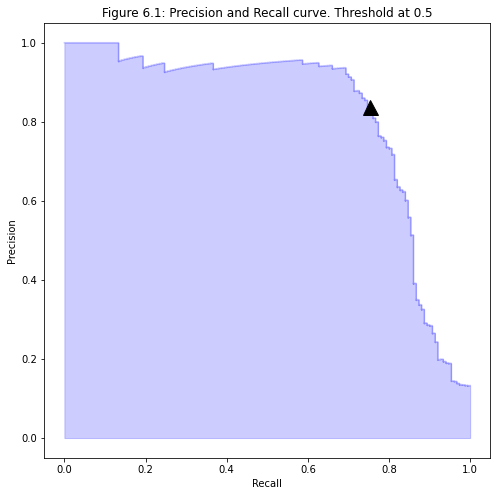

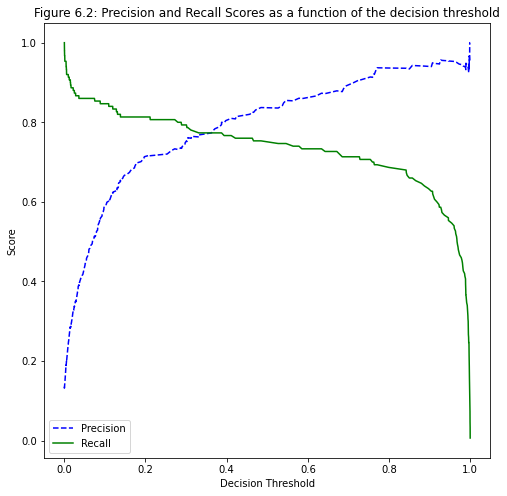

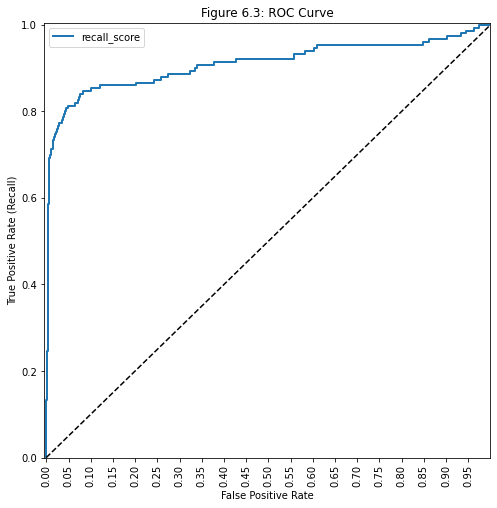

In [23]:
#3.3.3 Plot detailed report of for the best model
plot_reports(dl.y_test,y_scores,score_to_optimize,initial_threshold=0.5,title_prefix='Figure 6.')

Figures interpretation:

- Figure 6.1
Shows the Precision-Recall tradeoff and current threshold position there.
We see that futher optimizing for recall won't improve `recall` much but would
dramatically reduce the `precision` score.

- Figure 6.2
Shows both `precision` and `recall` scores as a function of the threshold.
It complements Figure 6.1 in the way that the threshold should not be further adjusted.


- Figure 6.3
Is the ROC Curve. Which can be interpreted as "how much our classifier does better than a random guess."
We see that the ROC curve is very good!
Actually, it's migh be to-good-to-be-true! I should not exclude the possibility 
that the model is overfitting due to some sort of data leakage.

Feature: international_plan, Score: 0.2608954906463623
Feature: voice_mail_plan, Score: 0.12016084045171738
Feature: number_vmail_messages, Score: 0.04120601713657379
Feature: total_day_minutes, Score: 0.0951744019985199
Feature: total_day_calls, Score: 0.023855485022068024
Feature: total_eve_minutes, Score: 0.042013008147478104
Feature: total_eve_calls, Score: 0.030472613871097565
Feature: total_night_minutes, Score: 0.02721640281379223
Feature: total_night_calls, Score: 0.019038571044802666
Feature: total_intl_minutes, Score: 0.06032373756170273
Feature: total_intl_calls, Score: 0.05165725201368332
Feature: number_customer_service_calls, Score: 0.20180296897888184
Feature: account_length_bin, Score: 0.026183191686868668


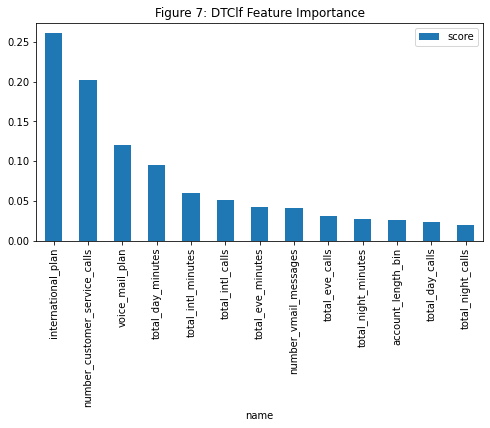

In [24]:
#3.3.4 Plot features importance
plot_feature_importance(importance,processor.features_names,'Figure 7: DTClf Feature Importance')



Features importance interpretations:

Top four important features in the model:
- `international_plan`
- `number_customer_service_calls`
- `voice_mail_plan`
- `total_day_minutes`. 

The pattern is actually so strong that it's visible in the pair plots! (Section 1.2, figure 4.3)

I measured the importance of the feature by obtaining `feature_importances_` metric, which is calculated 
by measuring how many splits were on that feature.

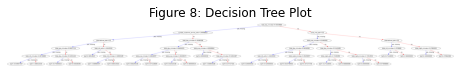

In [25]:
#Plot Tree
fig, ax = plt.subplots(figsize=(8,8))
# plot_tree(best_model['DTClf']
#                 ,rounded = True
#                 ,filled = True
#                 ,feature_names=processor.features_names
#                 ,class_names=True
#                 ,fontsize=5
#                 ,ax=ax
#                 )

plot_tree_xgb(best_model['XGBClf'],ax=ax,features_names=processor.features_names)


ax.set(title = 'Figure 8: Decision Tree Plot');


Potential next steps:

- Try out ensemble of different models and higher regularisation

- Investigate potential data leakage in the Decision Tree model

Since this exercise has time constraints, I didn't test the following hypothesis:

1) Investigate the geo-biased model and compare results.

The current model doesn't have `state` as a parameter, and I did it on purpose since the disbalance was found in the churn distribution by states (see Figure 2.1). It might be the temporal effect due to some business factors, so I don't want the model to judge based on where the user is from. The core assumption here 
is that `churn` event should be related to behavioral factors.
But this hypothesis is need to be tested by compare performance of both: `geo-aweard` and `geo-not-awared` models as well as 
by consulting with business users.

2) Even though the Regression model didn't pass the null threshold, it might be fine-tuned for a better score. Then, two models can be used 
as an ensemble to create a wotted prediction.

